In [100]:
# import the necessary packages
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time
from sklearn import metrics
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [98]:
INIT_LR = 1e-4
EPOCHS = 10
BATCHSIZE = 32

In [3]:
# Walk through directory and list number of files
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 4 directories and 0 images in 'train'.
There are 0 directories and 726 images in 'train\Closed'.
There are 0 directories and 725 images in 'train\no_yawn'.
There are 0 directories and 726 images in 'train\Open'.
There are 0 directories and 723 images in 'train\yawn'.


In [4]:
import pathlib

data_dir = pathlib.Path("train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)


['Closed' 'Open' 'no_yawn' 'yawn']


In [8]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img

['_304.jpg']
Image shape: (89, 89, 3)
['_645.jpg']
Image shape: (300, 329, 3)
['519.jpg']
Image shape: (480, 640, 3)
['2198.jpg']
Image shape: (480, 640, 3)


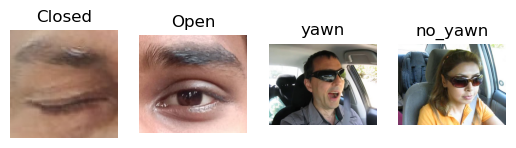

In [10]:
# Visualize the data
plt.figure()
plt.subplot(1, 4, 1)
closed_img = view_random_image("train/", "Closed")
plt.subplot(1, 4, 2)
open_img = view_random_image("train/", "Open")
plt.subplot(1, 4, 3)
yawn_img = view_random_image("train/", "yawn")
plt.subplot(1, 4, 4)
noyawn_img = view_random_image("train/", "no_yawn")

In [26]:
def face_for_yawn(direc="train", face_cas_path="prediction/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 256
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

yawn_no_yawn = face_for_yawn()

0
1


In [32]:
def open_closed_eye(dir_path="train", face_cas="prediction/haarcascade_frontalface_default.xml", eye_cas="prediction/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 256
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

data_train = open_closed_eye()

2
3


In [33]:
def append_data():
    d1 = face_for_yawn()
    d2 = open_closed_eye()
    d1.extend(d2)
    return d1

In [34]:
new_data = append_data()

0
1
2
3


In [47]:
import random
random.shuffle(new_data) # shuffling data for ignoring the biasness while training

x = list()
y = list()

for features, label in new_data:
    x.append(features)
    y.append(label)

x = np.array(x)
y = np.array(y)

In [49]:
print(len(x))
print(len(y))

print(x.shape)
print(y.shape)

1923
1923
(1923, 256, 256, 3)
(1923,)


In [67]:
import shutil
from random import sample

def create_test_dir(training_dir, test_dir, percentage=0.2):
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    subfolders = ['Closed', 'Open', 'no_yawn', 'yawn']

    for subfolder in subfolders:
        training_subfolder = os.path.join(training_dir, subfolder)
        test_subfolder = os.path.join(test_dir, subfolder)

        if not os.path.exists(test_subfolder):
            os.makedirs(test_subfolder)

        files = os.listdir(training_subfolder)
        selected_files = sample(files, int(len(files) * percentage))

        for file in selected_files:
            shutil.copy2(os.path.join(training_subfolder, file), test_subfolder)

In [69]:
create_test_dir('train', 'test')

In [90]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 30,
                                    zoom_range = 0.2,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.15,
                                    horizontal_flip = True,
                                    fill_mode = "nearest", 
                                    validation_split = 0.2)

test_data_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_data_gen.flow_from_directory("train",
                                                target_size = (256,256),
                                                batch_size=BATCHSIZE,
                                                class_mode='categorical',
                                                subset='training')

validation_data = train_data_gen.flow_from_directory("train",
                                                     target_size=(256,256),
                                                     batch_size=BATCHSIZE,
                                                     class_mode='categorical',
                                                     subset= 'validation')

test_data = test_data_gen.flow_from_directory("test",
                                              target_size=(256,256),
                                              batch_size=BATCHSIZE,
                                              class_mode='categorical')

Found 2321 images belonging to 4 classes.
Found 579 images belonging to 4 classes.
Found 579 images belonging to 4 classes.


In [93]:
baseModel = MobileNetV2(weights="imagenet", 
                        include_top=False, 
                        input_shape=(256, 256, 3))

baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [94]:
len(baseModel.layers)

154

In [101]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation = "softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs = baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers[:65]:
    layer.trainable = False
for layer in baseModel.layers[65:]:
    layer.trainable = True

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss = 'categorical_crossentropy', optimizer = opt,
    metrics=["accuracy"])

folder_path = pathlib.Path("run")
model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_model.h5"), monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(os.path.join(folder_path, f"log.csv"), separator=',', append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Start training time
start_time = time.time()

# train the head of the network
print("[INFO] training head...")
history = model.fit(train_data,
                    epochs = EPOCHS,
                    validation_data = validation_data,
                    callbacks=[model_checkpoint, csv_logger, early_stopping],
                    batch_size = BATCHSIZE
                    )

#Stop training time
end_time = time.time()
print(f"Training Time : {end_time - start_time}")

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
73/73 [==============================] - 91s 1s/step - loss: 0.1134 - accuracy: 0.9621 - val_loss: 0.3750 - val_accuracy: 0.9119
Epoch 2/10
73/73 [==============================] - 66s 907ms/step - loss: 0.0366 - accuracy: 0.9901 - val_loss: 0.2280 - val_accuracy: 0.9413
Epoch 3/10
73/73 [==============================] - 71s 972ms/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.2142 - val_accuracy: 0.9551
Epoch 4/10
73/73 [==============================] - 75s 1s/step - loss: 0.0231 - accuracy: 0.9914 - val_loss: 0.4299 - val_accuracy: 0.9223
Epoch 5/10
73/73 [==============================] - 69s 946ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.2442 - val_accuracy: 0.9637
Epoch 6/10
73/73 [==============================] - 71s 965ms/step - loss: 0.0244 - accuracy: 0.9953 - val_loss: 0.2766 - val_accuracy: 0.9551
Epoch 7/10
73/73 [==============================] - 74s 1s/step - loss: 0.0164 - accuracy: 0.9966 

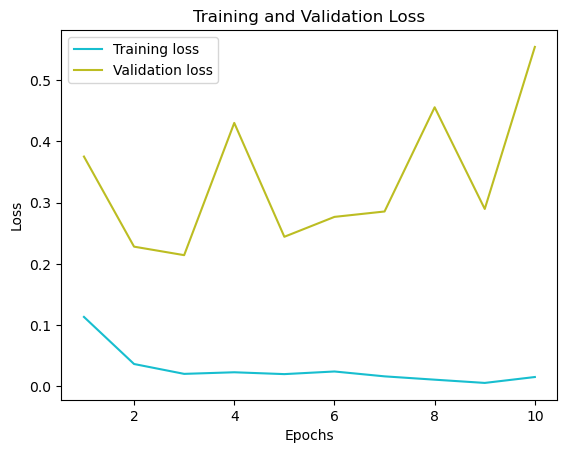

In [102]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'C9', label='Training loss')
plt.plot(epochs, val_loss, 'C8', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss.png'))
plt.show()

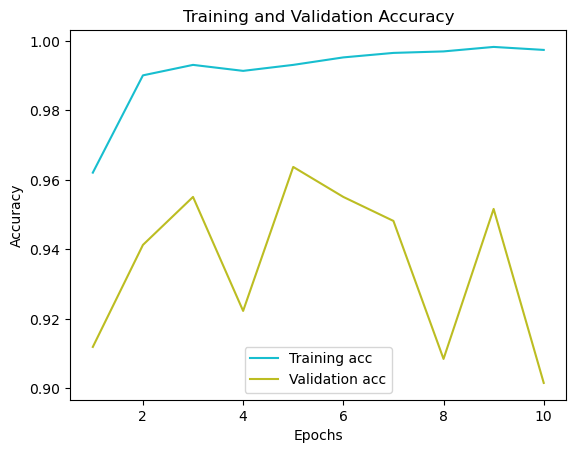

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'C9', label='Training acc')
plt.plot(epochs, val_acc, 'C8', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy.png'))
plt.show()

In [113]:
print("[INFO] evaluating network...")
Y_pred = model.predict(validation_data, batch_size = BATCHSIZE)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
classification_rep = classification_report(validation_data.classes, y_pred, 
                                           target_names = class_names, digits = 4)
print(classification_rep)

with open(os.path.join(folder_path, 'classification_report.txt'), 'w') as file:
    file.write(classification_rep)

[INFO] evaluating network...
19/19 [==============================] - 12s 616ms/step
Classification Report
              precision    recall  f1-score   support

      Closed     0.2185    0.2276    0.2230       145
        Open     0.2518    0.2414    0.2465       145
     no_yawn     0.2772    0.1931    0.2276       145
        yawn     0.3138    0.4097    0.3554       144

    accuracy                         0.2677       579
   macro avg     0.2653    0.2679    0.2631       579
weighted avg     0.2653    0.2677    0.2630       579



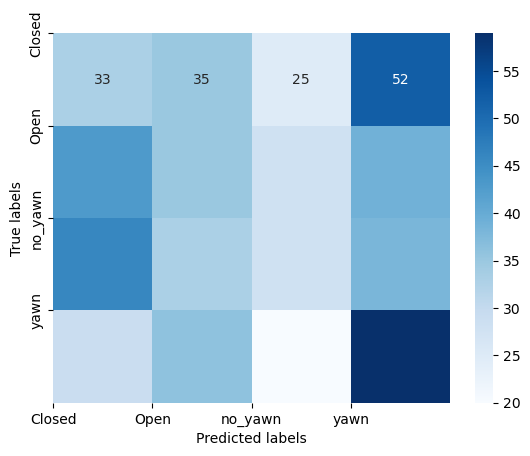

In [114]:
y_true = validation_data.classes
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join(folder_path, 'confusion matrix.png'))
plt.show()

In [121]:
saved_model_path = "run/best_model.h5"
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\tensorflow\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\anaconda3\envs\tensorflow\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\anaconda3\envs\tensorflow\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\tensorflowjs\converters\converter.py", line 29, in <module>
    import tensorflow.compat.v1 as tf1
ModuleNotFoundError: No module named 'tensorflow.compat'
